# Hierarchical Boundary Coefficient Clustering (HBCC)

HBCC is a boundary-based clustering algorithm based on the intuition that: (1)
points within a clusters have near neighbors on all sides, and (2) points
in-between clusters or on the edge of a cluster predominantly have neighbors in
the direction of the cluster's core. Vandaele et al.'s `boundary coefficient`
quantifies this intuition. HBCC interprets the `boundary coefficient` as a
distance, from which it creates a density-like profile. HDBSCAN's principled
density-based cluster extraction strategies are then used to detect
boundary-based clusters.


The relation between the boundary coefficient and local density is not
completely clear yet. Their main difference is that density only considers how
far away neighbors are, while the boundary coefficient also considers how spread
out they are. Typically, local density maxima occur towards the center of a
cluster (due to some Gaussian-like spread around a true centre). In that case,
the boundary coefficient agrees, neighbors are spread out around the local
density maximum. However, the boundary coefficient can have local minima in
places where there is not density maximum, allowing it to detect clusters that
are not detectable using density-based clustering.

To demonstrate this, consider a three-point star in which density decrease along
its arms:

In [ ]:
%load_ext autoreload
%autoreload 2

In [101]:
import numpy as np
import matplotlib.tri as mtri
import matplotlib.pyplot as plt

from scipy import linalg
from fast_hbcc import HBCC
from fast_hdbscan import HDBSCAN
from sklearn.utils import shuffle

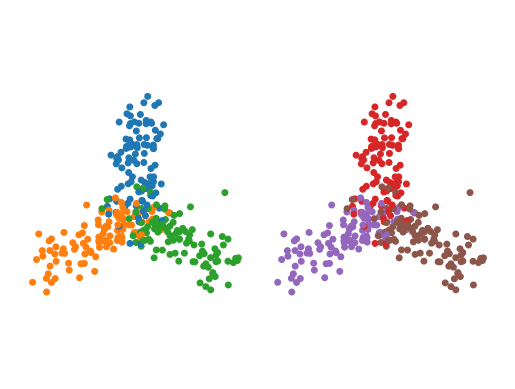

In [102]:
def make_star(num_samples=100, length=2, scale=0.02):
    """Creates a star with three branches.

    Datapoints are spaced logarithmically along the branch length,
    with the high-density part at the start of the branches.
    """

    def rotation(axis=[0, 0, 1], theta=0):
        return linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * theta))

    def rotate(X, axis=[0, 0, 1], theta=0):
        M = rotation(axis=axis, theta=theta)
        data = np.hstack((X, np.zeros((X.shape[0], 1), dtype=X.dtype)))
        return (M @ data.T).T[:, :2]

    max_exp = np.log(length)
    x = np.exp(np.linspace(0, max_exp, num_samples)) - 1
    branch = np.hstack((x[None].T, np.zeros((x.shape[0], 1), dtype=x.dtype)))
    X = np.vstack(
        (
            rotate(branch, theta=np.pi / 2),
            rotate(branch, theta=2 * np.pi / 3 + np.pi / 2),
            rotate(branch, theta=4 * np.pi / 3 + np.pi / 2),
        )
    )
    X += np.random.normal(scale=scale, size=X.shape)
    y = np.repeat([0, 1, 2], num_samples)
    X, y = shuffle(X, y)
    return X, y


X, y = make_star(length=1.5, scale=0.1 * np.sqrt(1 / 2))
X = np.concat((X, X + np.array([1.2, 0])))
y = np.concat((y, y + y.max() + 1))

kwargs = dict(s=16, cmap="tab10", vmin=0, vmax=9)
plt.scatter(*X.T, c=y, **kwargs)
plt.axis("equal")
plt.axis("off")
plt.show()

## Density-based clusters

Density-based clustering algorithms, like HDBSCAN, create a density-profile of
the data expressing how dense each part of the data space is. We show this
density profile in a 3D plot, where peaks correspond to high density values.

In [103]:
hdbscan = HDBSCAN(min_cluster_size=45, cluster_selection_method="leaf").fit(X)
density = 1 / hdbscan._core_distances

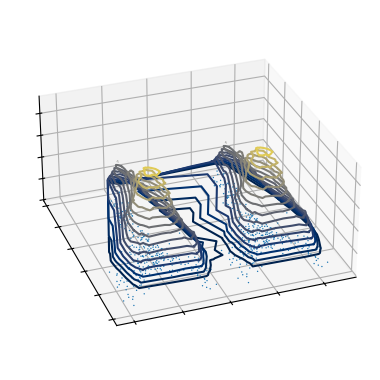

In [104]:
fig = plt.figure(figsize=(6, 3))
tri = mtri.Triangulation(X[:, 0], X[:, 1])
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=30, azim=-110)
ax.scatter(
    X[:, 0],
    X[:, 1],
    np.repeat(density.min(), X.shape[0]),
    s=1,
    alpha=1,
    edgecolor="none",
    linewidth=0,
)
ax.tricontour(
    tri,
    density,
    levels=np.exp(np.linspace(np.log(3.5), np.log(density.max()), 15)),
    cmap="cividis",
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
ax.set_box_aspect(aspect=(3, 3, 1.5))
plt.subplots_adjust(-0.1, -0.1, 1.1, 1.1)
plt.show()

Then, density-based algorithms create a cluster hierarchy. Imagine a plane
sliding down over the density-profile. The cluster hierarchy describes how the
peaks that poke through the plane merge as the plane slides down, forming a
`join tree`. HDBSCAN calls this hierarchy the `condensed_tree` and provides a
good plot for it. Notice that it plots density downward instead of upward!

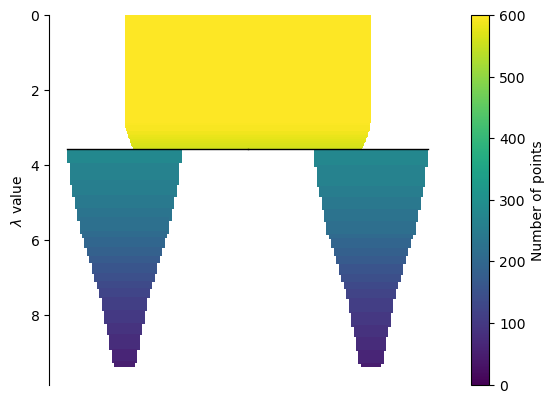

In [105]:
hdbscan.condensed_tree_.plot()
plt.show()

The density-profile and condensed tree plot show that density-based clustering
algorithm (in general) cannot detect this branching pattern. This is true for
all branching patterns in which the branches are not separated from the cluster
by a low density region and in which the branches do not contain a local density
maximum. In other words, branching patterns do not conform to the definition of
a cluster that density-based clustering algorithms use to detect clusters.

As a result, HDBSCAN finds the two stars as clusters, and ignores the branches:

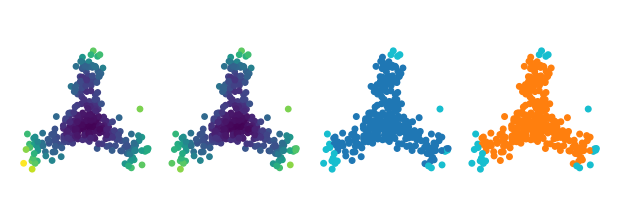

In [145]:
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=hdbscan._core_distances, s=15)
plt.axis("equal")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.scatter(*X.T, c=hdbscan.labels_ % 10, **kwargs)
plt.axis("equal")
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

## Boundary-based clusters

Clustering on a profile created from the boundary coefficient does find the
branches, as that profile contains local maxima within the branches:

In [141]:
hbcc = HBCC(
    num_hops=4,
    min_samples=10,
    min_cluster_size=20,
    cluster_selection_method="eom",
).fit(X)
coreness = 1 / hbcc.boundary_coefficient_

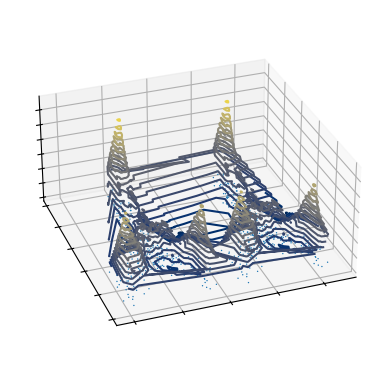

In [142]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 1, 1, projection="3d", computed_zorder=False)
ax.view_init(elev=30, azim=-110)
ax.scatter(
    X[:, 0],
    X[:, 1],
    np.repeat(coreness.min(), X.shape[0]),
    s=1,
    alpha=1,
    edgecolor="none",
    linewidth=0,
)
ax.tricontour(
    tri,
    coreness,
    levels=np.exp(np.linspace(np.log(1), np.log(coreness.max()), 20)),
    cmap="cividis",
)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
ax.set_box_aspect(aspect=(3, 3, 1.5))
plt.subplots_adjust(-0.1, -0.1, 1.1, 1.1)
plt.show()

As a result, the cluster hierarchy also captured the branches.

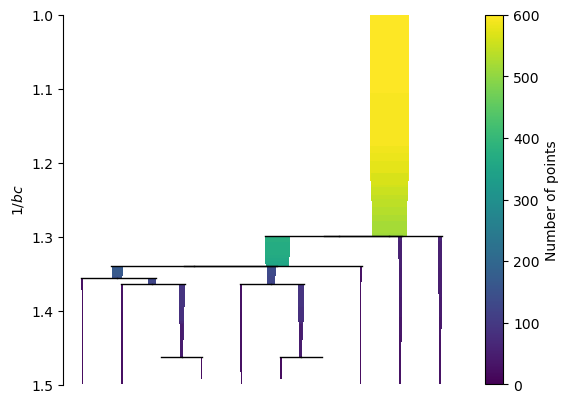

In [143]:
hbcc.condensed_tree_.plot()
plt.ylabel('$1 / bc$')
plt.ylim([1.5, 1])
plt.show()

And the branches can be selected as clusters:

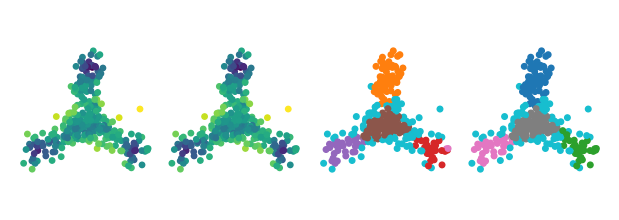

In [144]:
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=hbcc.boundary_coefficient_, s=15)
plt.axis("equal")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.scatter(*X.T, c=hbcc.labels_ % 10, **kwargs)
plt.axis("equal")
plt.axis("off")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

## Limitations: Noise Rejection

Detecting noise points is less effective when using the boundary coefficient in
place of core distances. CDC [4], the algorithm that inspired HBCC, addressed
this issue by running a noise-detection pre-processing step. HBCC does not have
such a step (yet). As a result, noise points can form clusters or create
connections between clusters in more complicated datasets.

In [146]:
data = np.load("data/flareable/flared_clusterable_data.npy")

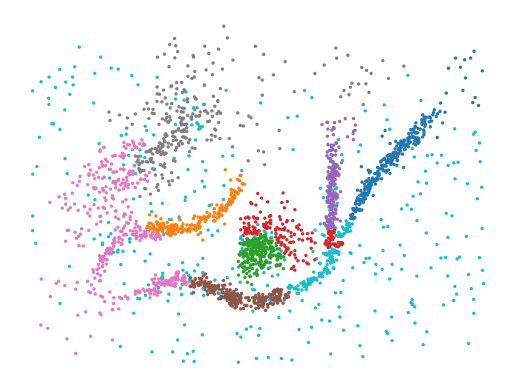

In [147]:
c = HBCC(min_cluster_size=100, cluster_selection_method="leaf").fit(data)
kwargs["s"] = 2
plt.scatter(*data.T, c=c.labels_ % 10, **kwargs)
plt.axis("off")
plt.show()

Tuning the boundary coefficient parameters can improve results. However, the
interaction between `num_points` and `min_samples` can be difficult to predict.
Both parameters influence the position and presence of local maxima in the
boundary coefficient profile. Generally, higher values result in a smooth
profile, which creates fewer, larger clusters.

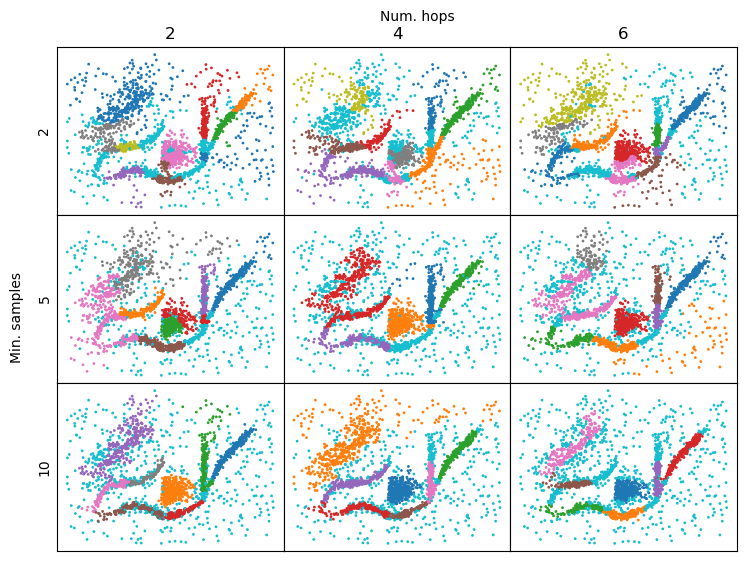

In [148]:
hops = [2, 4, 6]
samples = [2, 5, 10]
kwargs["s"] = 1
plt.figure(figsize=(8, 6))
cnt = 1
for samples in samples:
    for hop in hops:
        c = HBCC(
            num_hops=hop,
            min_samples=samples,
            min_cluster_size=100,
            cluster_selection_method="leaf",
        ).fit(data)
        plt.subplot(3, 3, cnt)
        if samples == 2:
            plt.title(hop)
        if hop == 2:
            plt.ylabel(samples)
        plt.scatter(*data.T, c=c.labels_ % 10, **kwargs)
        plt.xticks([])
        plt.yticks([])
        cnt += 1
plt.text(
    0,
    0.5,
    "Min. samples",
    rotation=90,
    va="center",
    ha="center",
    transform=plt.gcf().transFigure,
)
plt.text(
    0.5,
    1,
    "Num. hops",
    va="center",
    ha="center",
    transform=plt.gcf().transFigure,
)
plt.subplots_adjust(left=0.05, top=0.95, wspace=0, hspace=0)
plt.show()

## Operating on HDBSCAN clusters

Noise can also be rejected by first extracting larger HDBSCAN clusters and
computing boundary coefficient sub-clusters within each larger cluster. This
approach is also used by [FLASC](https://github.com/vda-lab/pyflasc) for branch
detection and supported by the
[fast_hdbscan](https://github.com/TutteInstitute/fast_hdbscan/) package.

In [149]:
from fast_hbcc import BoundaryClusterDetector

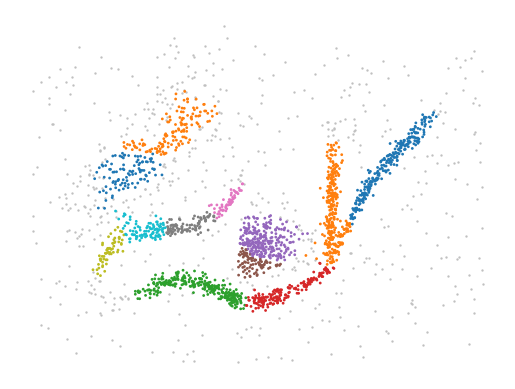

In [153]:
c = HDBSCAN(min_samples=10, min_cluster_size=40).fit(data)
d = BoundaryClusterDetector().fit(c)
mask = d.labels_ != -1
plt.scatter(*data[~mask].T, c='silver', s=)
plt.scatter(*data[mask].T, c=d.labels_[mask] % 10, **kwargs)
plt.axis("off")
plt.show()

Comparing the density and coreness profiles indicates that the boundary
coefficient indeed includes peaks that are not in the density profile. On the
other hand, peaks in the density profile tend to also exist in the coreness
profile, albeit with a less pronounced peak.

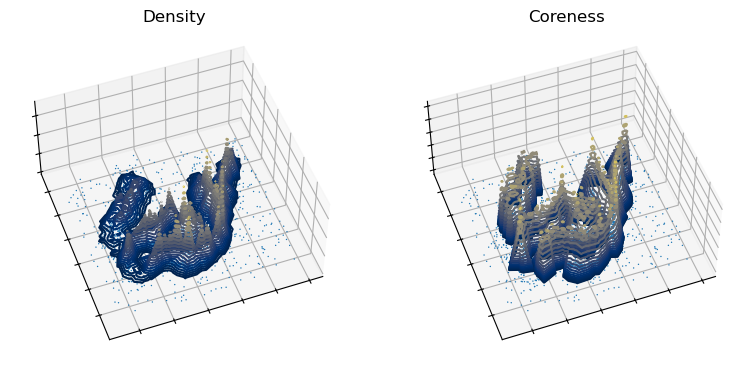

In [201]:
density = 1 / c._core_distances
with np.errstate(divide="ignore", invalid="ignore"):
    coreness = 1 / d.boundary_coefficient_
coreness = np.where(np.isinf(coreness), 0, coreness)

titles = ["Density", "Coreness"]
profiles = [density, coreness]
min_contour = [20, 0.1]

tri = mtri.Triangulation(data[:, 0], data[:, 1])
fig = plt.figure(figsize=(6, 3))
for i, (title, profile, min_c) in enumerate(zip(titles, profiles, min_contour)):
    ax = fig.add_subplot(1, 2, 1 + i, projection="3d", computed_zorder=False)
    plt.title(title)
    ax.view_init(elev=50, azim=-110)
    ax.scatter(
        data[:, 0],
        data[:, 1],
        np.repeat(profile.min(), data.shape[0]),
        s=1,
        alpha=1,
        edgecolor="none",
        linewidth=0,
    )
    ax.tricontour(
        tri,
        profile,
        levels=np.exp(np.linspace(np.log(min_c), np.log(profile.max()), 20)),
        cmap="cividis",
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    ax.set_box_aspect(aspect=(3, 3, 1.5))
plt.subplots_adjust(-0.1, -0.1, 1.1, 1.1)
plt.show()

Drawing the difference between the (normalized) profiles in color is slightly
easer to read. The blue points represent peaks in the coreness profile that do
not exist in the density profile. Red points indicate the opposite pattern.

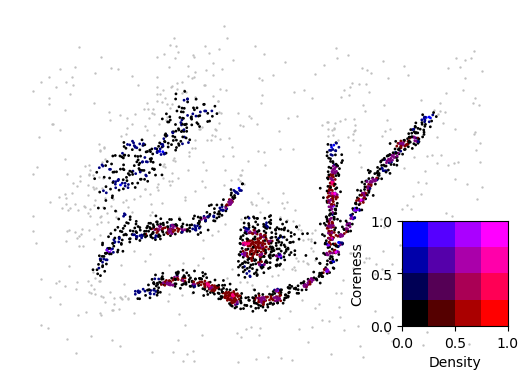

In [259]:
from matplotlib.colors import BoundaryNorm


def normalise(x):
    i = x.min()
    a = x.max()
    return (x - i) / (a - i)


n_density = normalise(density[mask])
n_coreness = normalise(coreness[mask])

norm = BoundaryNorm(np.linspace(0, 1, 4), 256)
fig = plt.figure()
plt.scatter(*data[~mask].T, c="silver", s=0.5)
plt.scatter(
    *data[mask].T,
    c=[(norm(d) / 256, 0, norm(c) / 256) for d, c in zip(n_density, n_coreness)],
    s=1
)
plt.axis("off")
fig.add_axes([0.72, 0.22, 0.2, 0.22])
X, Y = np.meshgrid(np.linspace(0, 1, 4), np.linspace(0, 1, 4))
Z = np.concat((X[:, :, None], np.zeros_like(X)[:, :, None], Y[:, :, None]), axis=2)
plt.imshow(Z, extent=(0, 1, 0, 1), origin="lower")
plt.xlabel("Density")
plt.ylabel("Coreness")
plt.show()